# CPPI
a dynamic allocation strategy which allows for insurannce (exposure to profit without
having the same exposure for loss).Downside protection and upside potential at once.

risky asset allocation =M*(portfolio value-floor value)
As portfolio reaches floor value your risky asset allocation becomes 0. Problem is that you 
may incur losses between two adjustments, called gap risk.Violation occurs if risky assets
depreciates by more than 1/M* risky portfolio value To overcome this one may trade frequently
but that results in trasnsaction costs.


If to reduce oppurtunity cost I also introduce a cap value then if current portfolio value nearer to cap
value then allocation changes to M*(cap value-portfolio value )

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
number =pd.read_csv("ind30_m_nfirms.csv",index_col=0,parse_dates=True)
size=pd.read_csv("ind30_m_size.csv",index_col=0,parse_dates=True) # this size means avg.value
number.index=pd.to_datetime(number.index,format="%Y%m").to_period("M")
size.index=pd.to_datetime(size.index,format="%Y%m").to_period("M")


C:\Users\91957\AppData\Local\Temp\ipykernel_20344\4201018737.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  number =pd.read_csv("ind30_m_nfirms.csv",index_col=0,parse_dates=True)
C:\Users\91957\AppData\Local\Temp\ipykernel_20344\4201018737.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  size=pd.read_csv("ind30_m_size.csv",index_col=0,parse_dates=True) # this size means avg.value


In [3]:
#returns=pd.read_csv('C:/Users/91957/Downloads/ind49_m_vw_rets.csv',header=0,index_col=0,parse_dates=True)/100
returns=pd.read_csv('ind49_m_vw_rets.csv',header=0,index_col=0,parse_dates=True)/100
returns.index=pd.to_datetime(returns.index,format="%Y%m").to_period("M")

C:\Users\91957\AppData\Local\Temp\ipykernel_20344\2037784200.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  returns=pd.read_csv('ind49_m_vw_rets.csv',header=0,index_col=0,parse_dates=True)/100


In [4]:
# market cap of each industry
marketcap=size*number


In [5]:
marketcap['total']=marketcap.sum(axis='columns')

In [6]:

marketcap.loc['192607']  #correct way to access it '1926-07' gives error

Food      1547.14
Beer        21.36
Smoke      955.52
Games      184.87
Books       24.04
Hshld      178.16
Clths      220.32
Hlth       178.64
Chems      979.03
Txtls       80.34
Cnstr      280.70
Steel     2185.20
FabPr      521.93
ElcEq     1218.58
Autos     1854.45
Carry      536.90
Mines      388.36
Coal       324.16
Oil       3989.97
Util      1705.62
Telcm     1751.80
Servs       40.80
BusEq      396.90
Paper      212.10
Trans     4951.34
Whlsl        2.38
Rtail     1539.45
Meals       64.92
Fin        225.96
Other       97.00
total    26657.94
Name: 1926-07, dtype: float64

In [7]:
marketcap_weights=marketcap.divide(marketcap['total'],axis='rows') 
# understand why rows came and not columns
marketcap_weights.loc['1926'].sum('columns')
#marketcap_weights.loc['192607'].sum('columns') not valid


1926-07    2.0
1926-08    2.0
1926-09    2.0
1926-10    2.0
1926-11    2.0
1926-12    2.0
Freq: M, dtype: float64

In [8]:
marketcap_weights=marketcap_weights.drop(columns='total')

<Axes: >

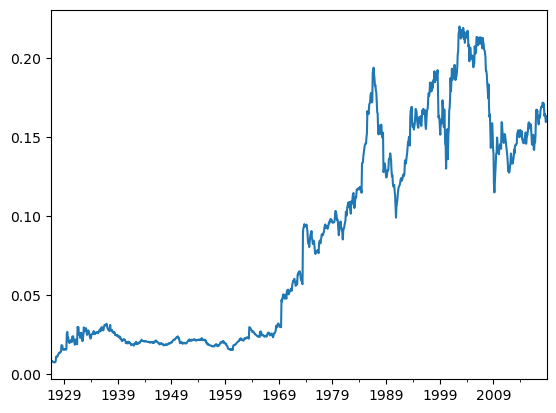

In [9]:
marketcap_weights.columns=marketcap_weights.columns.str.strip()
returns.columns=returns.columns.str.strip()
marketcap_weights['Fin'].plot()


In [10]:
# now calculating net market return of this weighted index
net_return=(marketcap_weights*returns).sum('columns')

<Axes: title={'center': 'weighted returns of index'}, xlabel='time', ylabel='returns'>

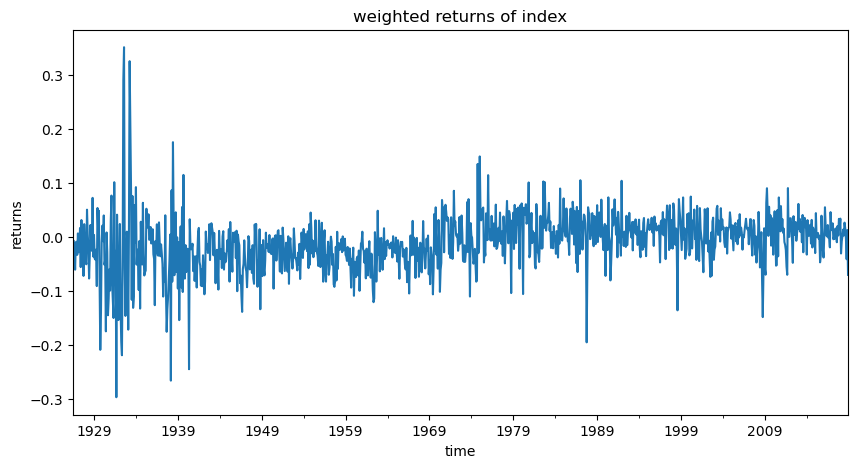

In [11]:
net_return.plot(figsize=(10,5),title="weighted returns of index",xlabel="time",ylabel='returns') #df.plot

In [12]:
net_return

1926-07   -0.006916
1926-08   -0.007228
1926-09   -0.030713
1926-10   -0.060863
1926-11   -0.010093
             ...   
2018-08    0.016009
2018-09   -0.003453
2018-10   -0.041502
2018-11    0.012652
2018-12   -0.070528
Freq: M, Length: 1110, dtype: float64

In [13]:
# making a risky and a safe asset 
risky=returns['2000':][['Steel',"Fin","Beer"]]

In [14]:
risky.shape

(228, 3)

In [15]:
# making a safe asset just as shape of a risky asset
safe=pd.DataFrame().reindex_like(risky)

In [16]:
safe[:]=0.04/12

In [17]:
safe.head()

,Steel,Fin,Beer
2000-01,0.003333,0.003333,0.003333
2000-02,0.003333,0.003333,0.003333
2000-03,0.003333,0.003333,0.003333
2000-04,0.003333,0.003333,0.003333
2000-05,0.003333,0.003333,0.003333


In [18]:
# to implement CPPI we will calculate cushion, make adjustments accordingly and then update portfolio
#value at each data point in this example


# backtesting CPPI

In [19]:
start=100
floor=0.75
floor_value=start*floor
steps=len(risky.index)
m=5

value_chart=pd.DataFrame().reindex_like(risky)
cushion_chart=pd.DataFrame().reindex_like(risky)
risky_weight_chart=pd.DataFrame().reindex_like(risky)


value=start
for n in range(steps):
    cushion=(value-floor_value)/value
    
    risky_weight=m*cushion
    
    
    risky_weight=np.minimum(1,risky_weight)
    #if risky_weight<0:    cannot be used as risky weight as a series sent to all different industries
    risky_weight=np.maximum(0,risky_weight)
    risky_alloc=value*risky_weight
    safe_alloc=value*(1-risky_weight)
    # returns realised at the end of the month so storing EOM values
    value=risky_alloc*(1+risky.iloc[n])+ safe_alloc*(1+safe.iloc[n])
    
    value_chart.iloc[n]=value
    cushion_chart.iloc[n]=cushion
    risky_weight_chart.iloc[n]=risky_weight

  

In [20]:
value_chart.head()

,Steel,Fin,Beer
2000-01,97.230000,93.190000,97.720000
2000-02,103.880532,99.309307,86.345392
2000-03,107.505963,113.947498,86.517865
2000-04,106.602912,99.635693,88.733581
2000-05,101.358049,92.720976,96.951347


<Axes: >

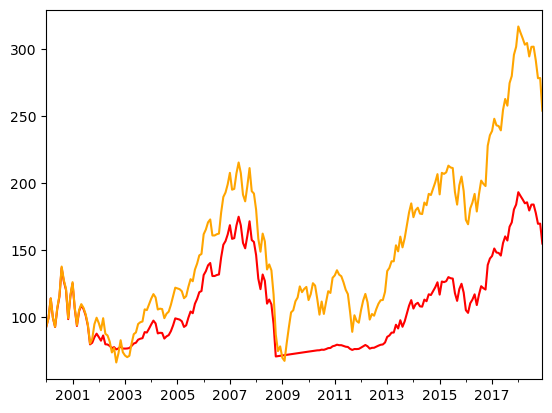

In [21]:
# plotting comparison of risky 100% and CPPI for finance sector
value_chart['Fin'].plot(color="red")
full_fin_portfolio=start*((1+returns['Fin']['2000':]).cumprod())
full_fin_portfolio.plot(color="orange")


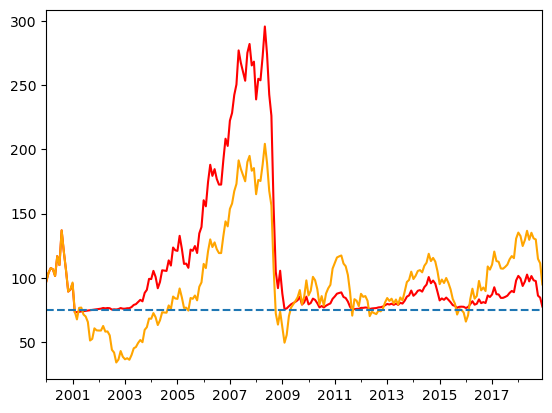

In [22]:
# another way to plot
obj=value_chart['Steel'].plot(color="red")
full_steel_portfolio=start*((1+returns['Steel']['2000':]).cumprod())
full_steel_portfolio.plot(ax=obj,color="orange")
obj.axhline(y=floor_value,linestyle='--')



In [33]:
import seaborn as sns

from the two graphs we can infer that cppi is especially helpful in distress situations like steel but it can have oppurtunity cost in better times. CPPI portfolio always have less deviation than standard
one

In [80]:
def cppi(returns,riskfree_rate,multiplier,floor,start=100):
    
    floor_value=start*floor
    steps=len(returns.index)
    m=multiplier
    
    if type(returns)==pd.DataFrame:
        safe=pd.DataFrame().reindex_like(returns)
        safe[:]=riskfree_rate
        value_chart=pd.DataFrame().reindex_like(returns)
    
    if type(returns)==pd.Series:
        safe=pd.Series().reindex_like(returns)
        safe[:]=riskfree_rate
        value_chart=pd.Series().reindex_like(returns)
   
    value=start
    for n in range(steps):
        cushion=(value-floor_value)/value

        risky_weight=m*cushion
        risky_weight=np.minimum(1,risky_weight)
        #if risky_weight<0:    cannot be used as risky weight as a series sent to all different industries
        risky_weight=np.maximum(0,risky_weight)
        risky_alloc=value*risky_weight
        safe_alloc=value*(1-risky_weight)
        
        value=risky_alloc*(1+returns.iloc[n])+ safe_alloc*(1+safe.iloc[n])
        value_chart.iloc[n]=value
    
    if type(returns)==pd.Series:
        full_risky_allocation=start*((1+returns).cumprod())
        value_chart.plot(title='cppi vs full risky',label='cppi',legend=True)
        plt.xlabel('time')
        plt.ylabel('wealth index')
        full_risky_allocation.plot(label="full risky",legend=True)
        plt.axhline(y=floor_value) 
    else:
        full_risky_allocation=start*((1+returns).cumprod())
        for x in returns.columns:
            plt.figure()
            plt.title("performance of  "+str(x)) 
            # syntax of using variables in title otherwise it does not accept
            plt.xlabel('time')
            plt.ylabel('wealth index')
            value_chart[x].plot(label='cppi',legend=True)
            full_risky_allocation[x].plot(label="full risky",legend=True )
            plt.axhline(y=floor_value)
            plt.show()
        

  

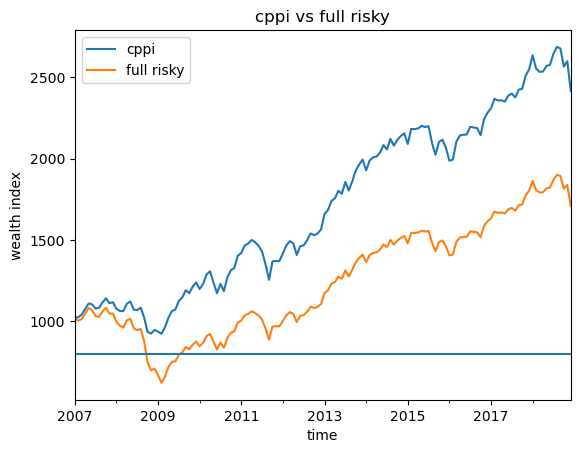

In [70]:
cppi(net_return['2007':],0.03,3,0.8,1000)

above graph proves that cppi could have saved you fairly from 2008 crash.

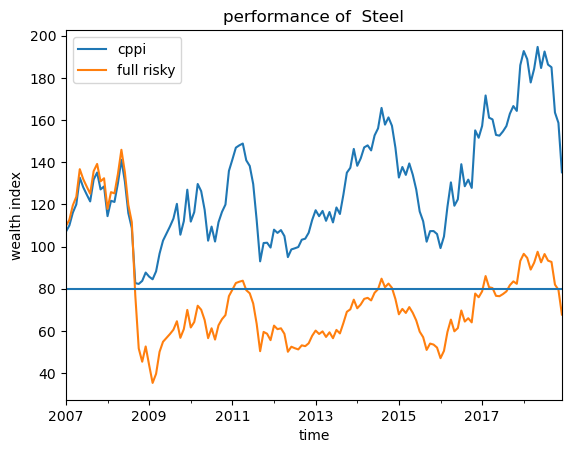

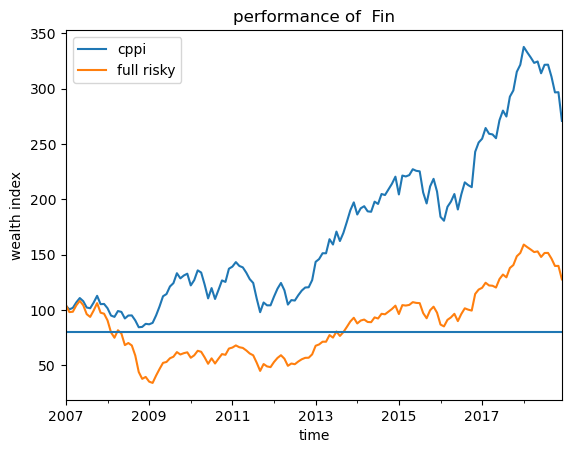

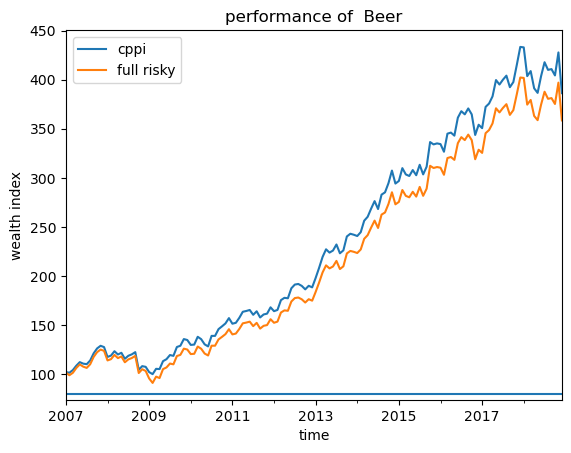

In [81]:
cppi(risky['2007':],0.03,3,0.8)

in real life CPPI would not be that much effective as there would be transaction costs and also we will
not be able to rebalance every month